Connected to real hardware: ibm_marrakesh
Submitting job to ibm_marrakesh...
Job ID: d5dbqfgnsj9s73babud0


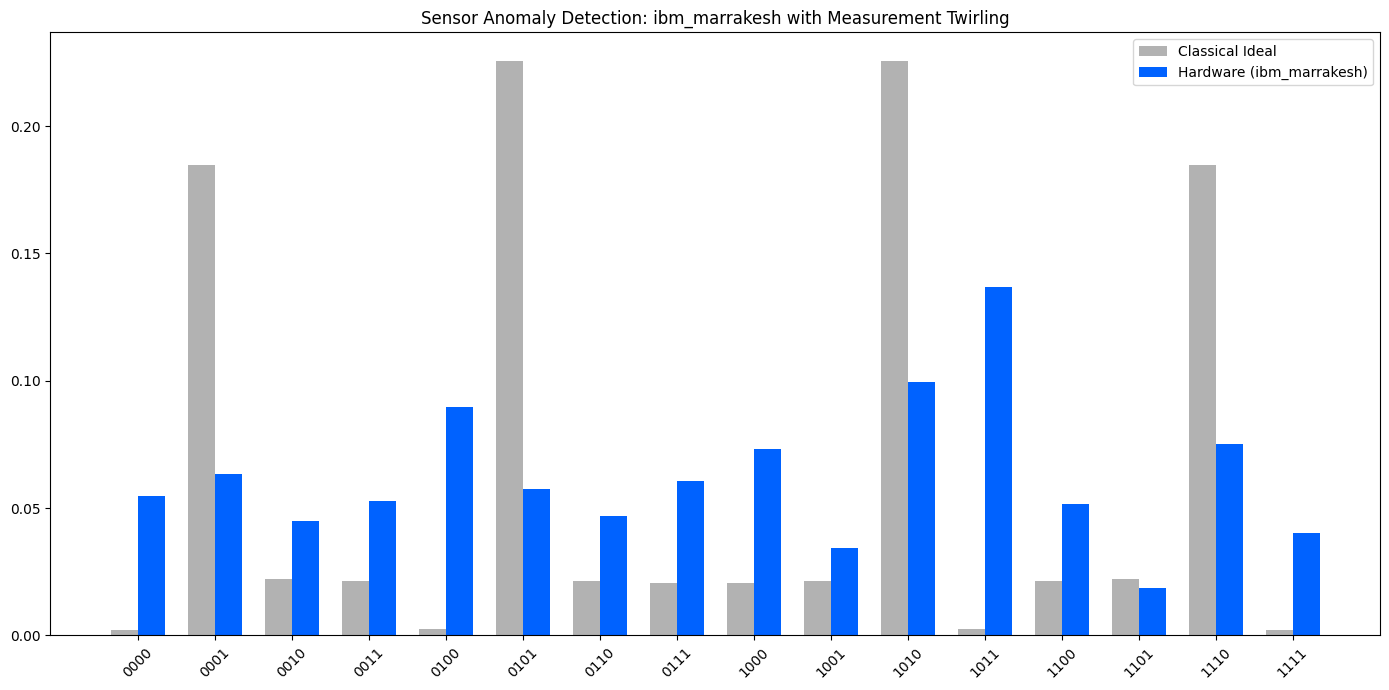

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sensors = {
    0: 18.9,
    1: 19.1,
    2: 18.8,
    3: 24.5  # <--- The Anomaly
}
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

hamiltonian_list = []
for i, j in edges:
    weight = abs(sensors[i] - sensors[j])
    pauli_str = ["I"] * 4
    pauli_str[i], pauli_str[j] = "Z", "Z"
    hamiltonian_list.append(("".join(pauli_str), weight))
ham_op = SparsePauliOp.from_list(hamiltonian_list)


# Replace with your actual credentials
token = "TOKEN"
instance = "CRN"

QiskitRuntimeService.save_account(
    token=token,
    channel="ibm_cloud",
    instance=instance,
    name="NAME",
    overwrite=True
)

service = QiskitRuntimeService(name="NAME")
backend = service.least_busy(operational=True, simulator=False)
print(f"Connected to real hardware: {backend.name}")


ansatz = QAOAAnsatz(ham_op, reps=2)
ansatz.measure_all()
fixed_qc = ansatz.assign_parameters([1.0, 1.0, 0.5, 0.5])

# Transpile for specific hardware (ISA)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(fixed_qc)

sampler = Sampler(mode=backend)


# 1. Enable Measurement Twirling (Crucial for readout error suppression)
sampler.options.twirling.enable_measure = True

# 2. Set default shots
sampler.options.default_shots = 1024

# 3. (Optional) Dynamical Decoupling for coherence preservation
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XX"

print(f"Submitting job to {backend.name}...")
job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")


result = job.result()[0].data.meas.get_counts()
total_shots = sum(result.values())
hw_probs = {k: v/total_shots for k, v in result.items()}

# Classical Benchmark Logic
states = [format(i, '04b') for i in range(16)]
def get_energy(b):
    spins = [1 if bit == '0' else -1 for bit in b]
    return sum(abs(sensors[i]-sensors[j]) * spins[i] * spins[j] for i, j in edges)

classical_vals = {s: np.exp(-get_energy(s)/5) for s in states}
c_total = sum(classical_vals.values())
classical_probs = {k: v/c_total for k, v in classical_vals.items()}

# Plotting
labels = sorted(states)
c_vals = [classical_probs[l] for l in labels]
h_vals = [hw_probs.get(l, 0) for l in labels]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, c_vals, width, label='Classical Ideal', color='gray', alpha=0.6)
plt.bar(x + width/2, h_vals, width, label=f'Hardware ({backend.name})', color='#0062ff')
plt.xticks(x, labels, rotation=45)
plt.title(f"Sensor Anomaly Detection: {backend.name} with Measurement Twirling")
plt.legend()
plt.tight_layout()
plt.show()

Running on local simulator: aer_simulator


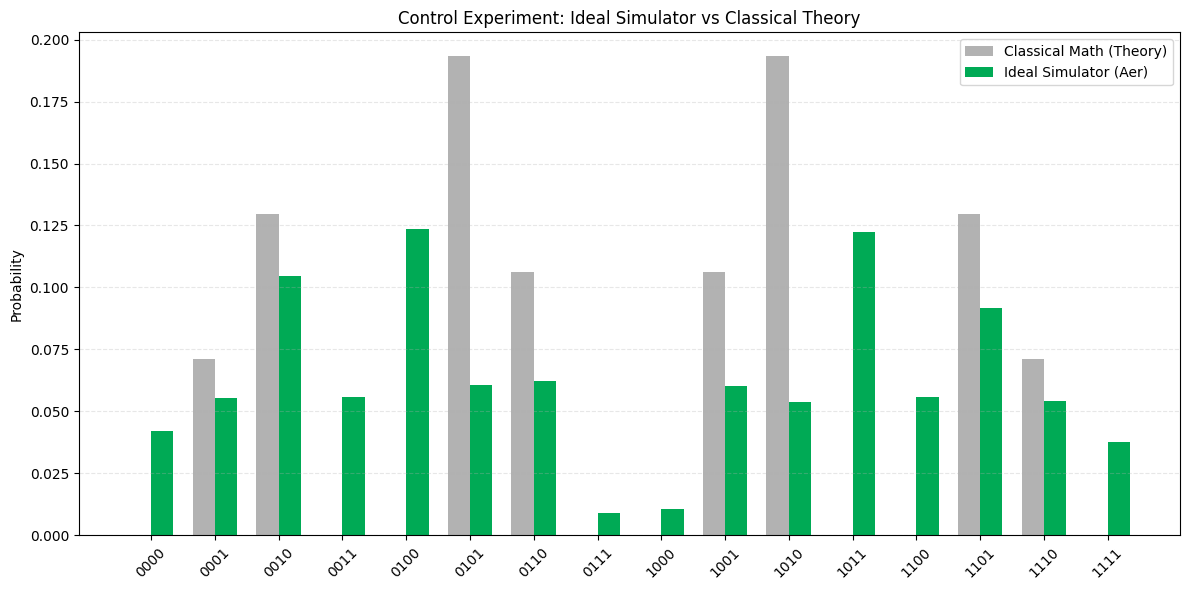

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator # Local simulator

sensors = {
    0: 18.9,
    1: 19.1,
    2: 18.8,
    3: 24.5  # <--- The Anomaly
}

edges = [(0, 1), (1, 2), (2, 3)]

# Create Hamiltonian
hamiltonian_list = []
scale_factor = 2.0  # Amplify differences

for i, j in edges:
    diff = abs(sensors[i] - sensors[j])
    weight = diff * scale_factor

    pauli_str = ["I"] * 4
    pauli_str[i], pauli_str[j] = "Z", "Z"
    hamiltonian_list.append(("".join(pauli_str), weight))

ham_op = SparsePauliOp.from_list(hamiltonian_list)


# No API token needed here
backend = AerSimulator()
print(f"Running on local simulator: {backend.name}")


ansatz = QAOAAnsatz(ham_op, reps=2)
ansatz.measure_all()
# Arbitrary parameters for the demo
fixed_qc = ansatz.assign_parameters([1.0, 1.0, 0.5, 0.5])

# Transpile for the simulator
t_qc = transpile(fixed_qc, backend)

job = backend.run(t_qc, shots=4000)
result = job.result()
counts = result.get_counts()

# Normalize simulation counts
total_shots = sum(counts.values())
sim_probs = {k: v/total_shots for k, v in counts.items()}


states = [format(i, '04b') for i in range(16)]

def get_energy(b):
    # Calculate energy of the graph cut
    # spins: 0 -> +1, 1 -> -1
    spins = [1 if bit == '0' else -1 for bit in b]
    total_energy = 0
    for i, j in edges:
        w = abs(sensors[i] - sensors[j]) * scale_factor
        total_energy += w * spins[i] * spins[j]
    return total_energy

# Create a Boltzmann distribution (Theoretical Ideal)
# Lower energy = Higher probability
energies = {s: get_energy(s) for s in states}
beta = 0.5 # Inverse temperature parameter
classical_unnormalized = {s: np.exp(-beta * e) for s, e in energies.items()}
norm_factor = sum(classical_unnormalized.values())
classical_probs = {k: v/norm_factor for k, v in classical_unnormalized.items()}

# --- 6. PLOTTING ---
labels = sorted(states)
c_vals = [classical_probs[l] for l in labels]
s_vals = [sim_probs.get(l, 0) for l in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))

# Classical Bars (Gray)
plt.bar(x - width/2, c_vals, width, label='Classical Math (Theory)', color='gray', alpha=0.6)

plt.bar(x + width/2, s_vals, width, label='Ideal Simulator (Aer)', color='#00aa55')

plt.xticks(x, labels, rotation=45)
plt.ylabel('Probability')
plt.title('Control Experiment: Ideal Simulator vs Classical Theory')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()